# **SVHN Dataset**
In the following exercices, you will work with the SVHN dataset: http://ufldl.stanford.edu/housenumbers/

It contains RGB images of street digits labeled from 1 to 10 similar to the MNIST dataset.

The train and test sets are provided in the folder Data/svhn/ in .mat format.
In the following we show an example of how to load the images and labels from these files. A DataLoader for this dataset is provided in the code examples for the lab.

Label: 1


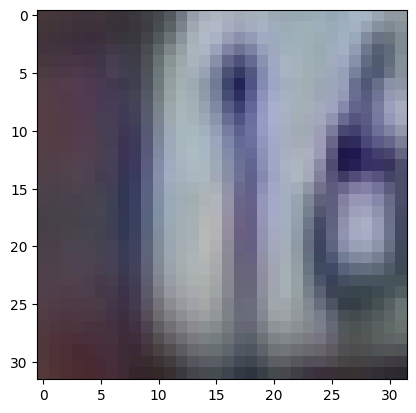

In [40]:
# Basic example loading images from the svhn dataset
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn

try: 
    base_path
except NameError:
    base_path = os.getcwd().replace('\\','/')
data_path = base_path + '/Data/'
results_path = base_path + '/Results/'

# Load mat file with train images from SVHN
import scipy.io as sio
train_mat = sio.loadmat(data_path + 'svhn/train_32x32.mat')

images = train_mat['X']
labels = train_mat['y'].squeeze()

example_image, example_label = images[:,:,:,20], labels[20] 

print('Label: ' + str(example_label))
plt.imshow(example_image)

# Ex. 1


'''
1. Try to obtain the maximum test accuracy possible in the SVHN dataset. For this purpose train/test different variants of the CNN provided in P3-Part1-Examples.
   You can explore different strategies:
1.1. Increase the size of the network by adding one ore more conv. layers. You can also increase the number of filters in each layer.
1.2. Try different optimizers such as Adam or SGD with momentum and modify the learning rate. You can check: https://pytorch.org/docs/stable/optim.html
1.3. Explore different random transformations during training ( Data augmentation ) such as random cropping with padding. 
You can check: https://pytorch.org/docs/stable/torchvision/transforms.html . Remember that these random transofrmation must not be used during testing.
1.4 Whatever you consider...


2. Save all the different models , compare their test accuracy and analyse the results. Discuss what model has been shown more effective and why have you used the different strategies.
'''

# Sol. 1

In [41]:
#Making native class loader
import PIL.Image as Image

class SVHN(torch.utils.data.Dataset):
    # Initialization method for the dataset
    def __init__(self,dataDir = data_path+'/svhn/train_32x32.mat',transform = None):
        mat_loaded = sio.loadmat(dataDir)
        self.data = mat_loaded['X']
        self.labels = mat_loaded['y'].squeeze()
        self.labels -= self.labels.min()
        self.transform = transform
     # What to do to load a single item in the dataset ( read image and label)    
    def __getitem__(self, index):
        data = self.data[:,:,:,index]
        lbl = self.labels[index]
        
        data = Image.fromarray(data)
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None : 
            data = self.transform(data)
        
        # return the image and the label
        return data,lbl
    
        pass
    
    # Return the number of images
    def __len__(self):
        return self.data.shape[3]


## Base CNN

In [42]:
# Define an standard CNN -> Two conv. blocks and linear layer 
import torch.nn as nn
class BaseConvNet(nn.Module):
    def __init__(self, num_classes=10):
        
        super(BaseConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5,  padding=2)
        #input : 3 channel, output 16 channel, filter size : 5x5 and padding 2
        # the ouput of this channel will be 16x32x32 (assuming our image is in fact 32x32) since the pixels
        # that the convolution operation collapses into are 32x32 (the padding is 2 so the image is not reduced)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3,  padding=1)
        #input : 16 channel, output 32 channel, filter size : 3x3
        # simmilary the output of this channel will be 32x32x32. If the kernel is 3x3, then the dimensions are reduced by
        # 2 (since the padding is 1) in both height and width, but the padding counters this.
        
        self.fc = nn.Linear(8*8*32, num_classes)
        # must match the previous dimensions in the input. In the case of the SVHM dataset, the input is 32x32x3, and after
        # doing 2 convolutions that do not reduce the height and width, but 2 maxpooling operations after the convolutions, the
        # dimensions are 8x8x32, since the final channel number is 32. The 8*8*32 is the number of pixels in the image after the 
        # convolutions, and the number of channels
        
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU().cuda()
        
    def forward(self, x):
        
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = out.reshape(out.size(0), -1) 
        out = self.fc(out) # we don't need sigmoid or other activation function at the end beacuse we will use nn.CrossEntropyLoss() (check documentation to understand why)
        
        return out 



In [43]:
# Train function
def train(CNN, train_loader, optimizer, num_epochs=5, model_name='model.ckpt', device='cpu'):
    CNN.train() # Set the model in train mode
    total_step = len(train_loader)
    losses_list = []
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        for i, (images, labels) in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = CNN(images)
            loss = criterion(outputs, labels)
            losses_list.append(loss.item())
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                        .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
          
    torch.save(CNN.state_dict(), results_path + model_name)
    return losses_list 

# Test funcion
def test(CNN, test_loader,device='cpu'):
  with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            # get network predictions
            images = images.to(device)
            labels = labels.to(device)
            outputs = CNN(images)

            # get predicted class
            _, predicted = torch.max(outputs.data, 1)

            # compare with the ground-truth
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # return accuracy
        return 100 * correct / total

In [44]:
BaseCNN = BaseConvNet()
# CNN = CNN.cuda()
import torchvision.transforms as tf

# Create train data loader
tr = tf.Compose([
        tf.ToTensor(), 
        tf.Normalize(mean = [.5], std = [.5]),
        ])
SVHNTrain = SVHN(data_path+'/svhn/train_32x32.mat',tr)
train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain,
                                               batch_size=256, 
                                               shuffle=True)

SVHNTest = SVHN(data_path+'/svhn/test_32x32.mat',tr)
test_loader = torch.utils.data.DataLoader(dataset=SVHNTest,
                                               batch_size=256, 
                                               shuffle=True)

Epoch [1/5], Step [100/287], Loss: 0.9781
Epoch [1/5], Step [200/287], Loss: 0.8659
Epoch [2/5], Step [100/287], Loss: 0.5553
Epoch [2/5], Step [200/287], Loss: 0.4359
Epoch [3/5], Step [100/287], Loss: 0.5253
Epoch [3/5], Step [200/287], Loss: 0.5064
Epoch [4/5], Step [100/287], Loss: 0.3726
Epoch [4/5], Step [200/287], Loss: 0.4984
Epoch [5/5], Step [100/287], Loss: 0.3975
Epoch [5/5], Step [200/287], Loss: 0.4517


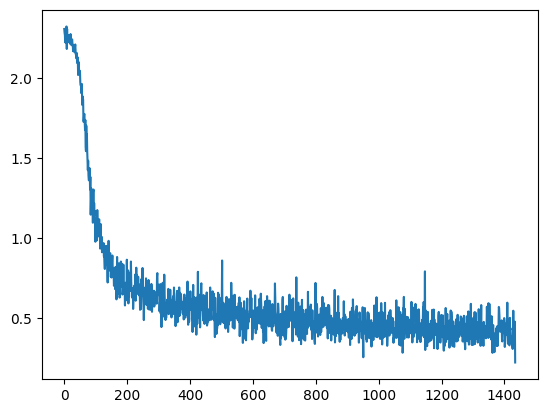

Test accuracy is: 86.68561770129072 %


In [45]:
# Cross entropy loss for classification problems
criterion = nn.CrossEntropyLoss()

#Initialize optimizer 
learning_rate = .001
optimizer = torch.optim.Adam(BaseCNN.parameters(),lr = learning_rate)


# Device configuration (choose GPU if it is available )
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
BaseCNN.to(device)
num_epochs = 5

# Train and test the model
loss_hist = train(BaseCNN, train_loader, optimizer, num_epochs, model_name='base_model.pkt', device=device)
plt.plot(loss_hist)
plt.show()


print('Test accuracy is: {} %'.format(test(BaseCNN, test_loader,device=device)))
# Create test data loader


## Refined CNN's

We will not create a CNN class for each hyperparameter configuration. Instead, we will change the RefinedConvNet class

### More Layers or different architecture

In [46]:
# Define an standard CNN -> Two conv. blocks and linear layer 
import torch.nn as nn
class LongConvNet(nn.Module):
    def __init__(self, num_classes=10):
        
        super(LongConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5,  padding=2) 
        # after maxpooling, the dimensions are 16x16x16
    
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        # after maxpooling, the dimensions are 7x7x32

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # after maxpooling, the dimensions are 3x3x64
        
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv3(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = out.reshape(out.size(0), -1) 
        out = self.fc1(out)
        out = self.relu(out)

        out = self.fc2(out)
        
        return out 



Epoch [1/5], Step [100/287], Loss: 0.9969
Epoch [1/5], Step [200/287], Loss: 0.7980
Epoch [2/5], Step [100/287], Loss: 0.6114
Epoch [2/5], Step [200/287], Loss: 0.5812
Epoch [3/5], Step [100/287], Loss: 0.4833
Epoch [3/5], Step [200/287], Loss: 0.3740
Epoch [4/5], Step [100/287], Loss: 0.3085
Epoch [4/5], Step [200/287], Loss: 0.3373
Epoch [5/5], Step [100/287], Loss: 0.2618
Epoch [5/5], Step [200/287], Loss: 0.2583


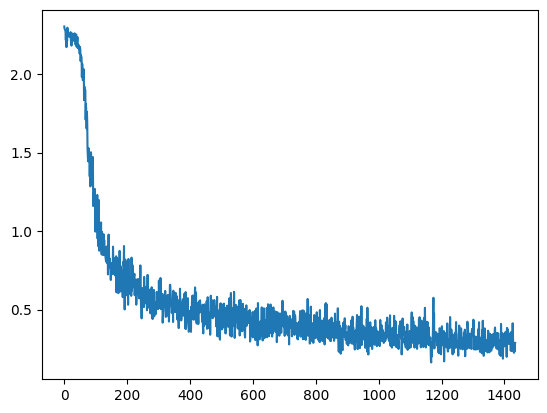

Test accuracy is: 90.0737553779963 %


In [47]:
LongCNN = LongConvNet()

criterion = nn.CrossEntropyLoss()

#Initialize optimizer 
learning_rate = .001

# Device configuration (choose GPU if it is available )
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
LongCNN.to(device)
num_epochs = 5

optimizer = torch.optim.Adam(LongCNN.parameters(),lr = learning_rate)

loss_hist = train(LongCNN, train_loader, optimizer, num_epochs, model_name='long_model.pkt', device=device)
# plot the loss history with a white background
plt.plot(loss_hist)
plt.show()


print('Test accuracy is: {} %'.format(test(LongCNN, test_loader,device=device)))
# Create test data loader

### Different Optimizers

Epoch [1/5], Step [100/287], Loss: 0.8797
Epoch [1/5], Step [200/287], Loss: 0.6279
Epoch [2/5], Step [100/287], Loss: 0.8246
Epoch [2/5], Step [200/287], Loss: 0.4926
Epoch [3/5], Step [100/287], Loss: 0.6334
Epoch [3/5], Step [200/287], Loss: 0.4390
Epoch [4/5], Step [100/287], Loss: 0.6165
Epoch [4/5], Step [200/287], Loss: 0.4553
Epoch [5/5], Step [100/287], Loss: 0.3287
Epoch [5/5], Step [200/287], Loss: 0.4044


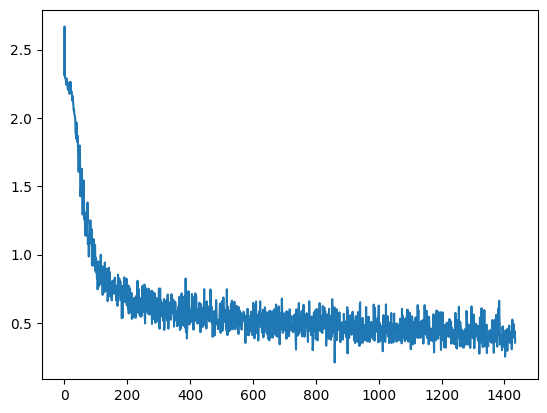

Test accuracy is: 83.50875845113706 %


In [48]:
# Cross entropy loss for classification problems
RMSpropCNN = BaseConvNet()
criterion = nn.CrossEntropyLoss()

#Initialize optimizer 
learning_rate = .001
optimizer_RMSpropCNN = torch.optim.RMSprop(RMSpropCNN.parameters(),lr = learning_rate)


# Device configuration (choose GPU if it is available )
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
RMSpropCNN.to(device)
num_epochs = 5

# Train and test the model
loss_hist = train(RMSpropCNN, train_loader, optimizer_RMSpropCNN, num_epochs, model_name='rmsprop_model.pkt', device=device)
plt.plot(loss_hist)
plt.show()


print('Test accuracy is: {} %'.format(test(RMSpropCNN, test_loader,device=device)))
# Create test data loader

Epoch [1/5], Step [100/287], Loss: 2.1617
Epoch [1/5], Step [200/287], Loss: 2.1050
Epoch [2/5], Step [100/287], Loss: 2.0291
Epoch [2/5], Step [200/287], Loss: 2.0318
Epoch [3/5], Step [100/287], Loss: 1.9063
Epoch [3/5], Step [200/287], Loss: 1.9018
Epoch [4/5], Step [100/287], Loss: 1.8974
Epoch [4/5], Step [200/287], Loss: 1.7909
Epoch [5/5], Step [100/287], Loss: 1.8098
Epoch [5/5], Step [200/287], Loss: 1.7356


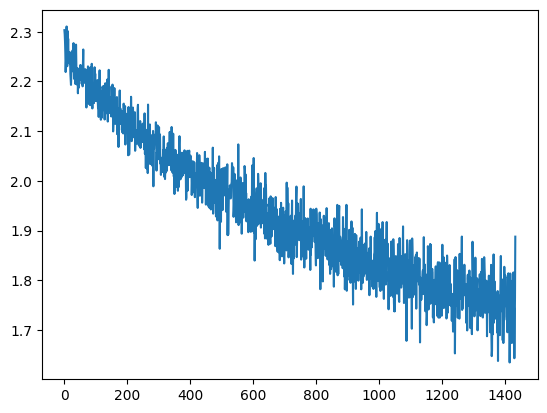

Test accuracy is: 42.58220651505839 %


In [49]:
# Cross entropy loss for classification problems
SGDGCNN = BaseConvNet()
criterion = nn.CrossEntropyLoss()

#Initialize optimizer 
learning_rate = .1
optimizer_SGD = torch.optim.SGD(SGDGCNN.fc.parameters(),lr = learning_rate, weight_decay=1e-5, momentum=0.9)


# Device configuration (choose GPU if it is available )
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
SGDGCNN.to(device)
num_epochs = 5

# Train and test the model
loss_hist = train(SGDGCNN, train_loader, optimizer_SGD, num_epochs, model_name='SGD_model.pkt', device=device)
plt.plot(loss_hist)
plt.show()


print('Test accuracy is: {} %'.format(test(SGDGCNN, test_loader,device=device)))
# Create test data loader

### Transormations

In [50]:
# Create train data loader
max_degree = 10
tr_rot = tf.Compose([
        tf.ToTensor(), 
        tf.Normalize(mean = [.5], std = [.5]),
        tf.RandomRotation(max_degree)
        ])

SVHNTrain_rot = SVHN(data_path+'/svhn/train_32x32.mat',tr_rot)
train_loader_rot = torch.utils.data.DataLoader(dataset=SVHNTrain_rot,
                                               batch_size=256, 
                                               shuffle=True)



In [51]:
# Create train data loader
max_degree = 10
tr_crop = tf.Compose([
        tf.ToTensor(), 
        tf.Normalize(mean = [.5], std = [.5]),
        tf.RandomCrop(32, padding=4)
        ])
SVHNTrain_crop = SVHN(data_path+'/svhn/train_32x32.mat',tr_crop)
train_loader_crop = torch.utils.data.DataLoader(dataset=SVHNTrain_crop,
                                               batch_size=256, 
                                               shuffle=True)




Epoch [1/5], Step [100/287], Loss: 1.5854
Epoch [1/5], Step [200/287], Loss: 1.2480
Epoch [2/5], Step [100/287], Loss: 1.0459
Epoch [2/5], Step [200/287], Loss: 1.0323
Epoch [3/5], Step [100/287], Loss: 0.8460
Epoch [3/5], Step [200/287], Loss: 0.9197
Epoch [4/5], Step [100/287], Loss: 0.9302
Epoch [4/5], Step [200/287], Loss: 0.8816
Epoch [5/5], Step [100/287], Loss: 0.8213
Epoch [5/5], Step [200/287], Loss: 0.8283


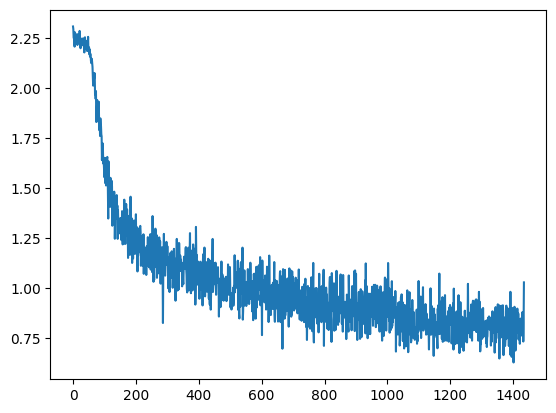

Test accuracy is: 85.84050399508297 %


In [52]:
BaseCNN = BaseConvNet()

criterion = nn.CrossEntropyLoss()

#Initialize optimizer 
learning_rate = .001
optimizer = torch.optim.Adam(BaseCNN.parameters(), lr = learning_rate)


# Device configuration (choose GPU if it is available )
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
BaseCNN.to(device)
num_epochs = 5

# Train and test the model
loss_hist = train(BaseCNN, train_loader_crop, optimizer, num_epochs, model_name='cropped_model.pkt', device=device)
plt.plot(loss_hist)
plt.show()


print('Test accuracy is: {} %'.format(test(BaseCNN, test_loader,device=device)))

Epoch [1/5], Step [100/287], Loss: 1.3046
Epoch [1/5], Step [200/287], Loss: 0.6830
Epoch [2/5], Step [100/287], Loss: 0.6723
Epoch [2/5], Step [200/287], Loss: 0.6263
Epoch [3/5], Step [100/287], Loss: 0.5865
Epoch [3/5], Step [200/287], Loss: 0.4409
Epoch [4/5], Step [100/287], Loss: 0.4996
Epoch [4/5], Step [200/287], Loss: 0.5067
Epoch [5/5], Step [100/287], Loss: 0.4640
Epoch [5/5], Step [200/287], Loss: 0.5239


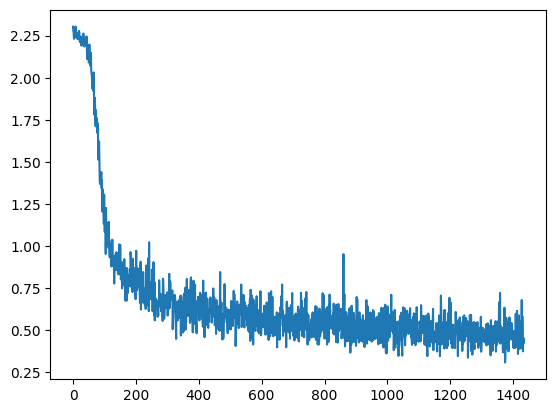

Test accuracy is: 86.78549477566072 %


In [53]:
BaseCNN = BaseConvNet()

criterion = nn.CrossEntropyLoss()

#Initialize optimizer 
learning_rate = .001
optimizer = torch.optim.Adam(BaseCNN.parameters(), lr = learning_rate)


# Device configuration (choose GPU if it is available )
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
BaseCNN.to(device)
num_epochs = 5

# Train and test the model
loss_hist = train(BaseCNN, train_loader_rot, optimizer, num_epochs, model_name='rotated_model.pkt', device=device)
plt.plot(loss_hist)
plt.show()


print('Test accuracy is: {} %'.format(test(BaseCNN, test_loader,device=device)))

### Other Alternatives

#### Schedulers

In [54]:
# Train function
import torch.optim.lr_scheduler as lrs
def train_sched(CNN, train_loader, optimizer, num_epochs=5, model_name='scheduled_model.ckpt', device='cpu', scheduler=None,criterion=nn.CrossEntropyLoss()):
    CNN.train() # Set the model in train mode
    if scheduler is not None: scheduler = lrs.ExponentialLR(optimizer, gamma=0.95) 
    total_step = len(train_loader)
    losses_list = []
    
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        loss_avg = 0
        nBatches = 0
        for i, (images, labels) in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.type(torch.LongTensor).to(device)

            # Forward pass
            outputs = CNN(images)
            loss = criterion(outputs, labels)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses_list.append(loss.cpu().item())
            loss_avg += loss.cpu().item()
            nBatches+=1
            if (i+1) % 100 == 0:
                if scheduler is not None:
                    for param_group in optimizer.param_groups:
                        print("Current learning rate is: {}".format(param_group['lr']))
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        if scheduler is not None: scheduler.step()
        

        # losses_list.append(loss_avg / nBatches)
        torch.save(CNN.state_dict(), results_path+ '/' + model_name)
    return losses_list

Current learning rate is: 0.001
Epoch [1/5], Step [100/287], Loss: 1.8052
Current learning rate is: 0.001
Epoch [1/5], Step [200/287], Loss: 1.2950
Epoch [1/5], Step [287/287], Loss: 1.0946
Current learning rate is: 0.00095
Epoch [2/5], Step [100/287], Loss: 0.5822
Current learning rate is: 0.00095
Epoch [2/5], Step [200/287], Loss: 0.5720
Epoch [2/5], Step [287/287], Loss: 0.5593
Current learning rate is: 0.0009025
Epoch [3/5], Step [100/287], Loss: 0.5026
Current learning rate is: 0.0009025
Epoch [3/5], Step [200/287], Loss: 0.5053
Epoch [3/5], Step [287/287], Loss: 0.5002
Current learning rate is: 0.000857375
Epoch [4/5], Step [100/287], Loss: 0.4714
Current learning rate is: 0.000857375
Epoch [4/5], Step [200/287], Loss: 0.4665
Epoch [4/5], Step [287/287], Loss: 0.4618
Current learning rate is: 0.0008145062499999999
Epoch [5/5], Step [100/287], Loss: 0.4252
Current learning rate is: 0.0008145062499999999
Epoch [5/5], Step [200/287], Loss: 0.4280
Epoch [5/5], Step [287/287], Loss: 0

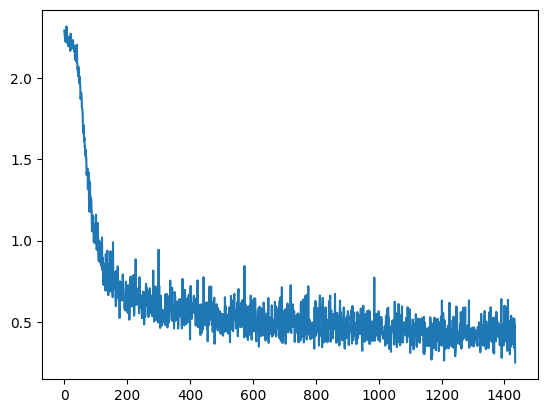

Test accuracy is: 86.34757221880763 %


In [55]:
BaseCNN = BaseConvNet()

criterion = nn.CrossEntropyLoss()

#Initialize optimizer 
learning_rate = .001
optimizer = torch.optim.Adam(BaseCNN.parameters(), lr = learning_rate)


# Device configuration (choose GPU if it is available )
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
BaseCNN.to(device)
num_epochs = 5

# Train and test the model
loss_hist = train_sched(BaseCNN, train_loader, optimizer, num_epochs, model_name='scheduled_model.pkt', device=device, scheduler=True)
plt.plot(loss_hist)
plt.show()


print('Test accuracy is: {} %'.format(test(BaseCNN, test_loader,device=device)))

#### Batch Hard

In [56]:
def get_batch_hard(CNN, train_loader, prop=0.7, device='cpu'):
    with torch.no_grad():
        losses = []
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            # get network predictions
            outputs = CNN(images)
            # get loss
            loss = criterion(outputs, labels)
            losses.append(loss)
        losses = torch.stack(losses)
        losses = losses.cpu().numpy()
        idx = np.argsort(losses)[::-1]
        idx_hard_batches = idx[:int(len(train_loader)*prop)]
        return idx_hard_batches


def train_hard(CNN, train_loader, optimizer, num_epochs=5, prop=0.7, model_name='hard_model.ckpt', device='cpu', scheduler=None):

# get the batches to run through the model
    idx_hard = get_batch_hard(CNN, train_loader, prop=prop, device=device)
    CNN.train() # Set the model in train mode
    if scheduler is not None: scheduler = lrs.ExponentialLR(optimizer, gamma=0.95) 
    total_step = len(train_loader)
    losses_list = []
    
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        loss_avg = 0
        nBatches = 0
        for i, (images, labels) in enumerate(train_loader):
            if i not in idx_hard: continue
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.type(torch.LongTensor).to(device)

            # Forward pass
            outputs = CNN(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses_list.append(loss.cpu().item())
            loss_avg += loss.cpu().item()
            nBatches+=1
            if (i+1) % 100 == 0:
                if scheduler is not None:
                    for param_group in optimizer.param_groups:
                        print("Current learning rate is: {}".format(param_group['lr']))
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        if scheduler is not None: scheduler.step()
        

        # losses_list.append(loss_avg / nBatches)
        torch.save(CNN.state_dict(), results_path+ '/' + model_name)
          
    return losses_list 

Epoch [1/3], Step [100/287], Loss: 1.1352
Epoch [1/3], Step [200/287], Loss: 0.6170
Epoch [2/3], Step [100/287], Loss: 0.7614
Epoch [2/3], Step [200/287], Loss: 0.5461
Epoch [3/3], Step [100/287], Loss: 0.6141
Epoch [3/3], Step [200/287], Loss: 0.5333
Epoch [1/2], Step [100/287], Loss: 0.4609
Epoch [1/2], Step [287/287], Loss: 0.4609
Epoch [2/2], Step [100/287], Loss: 0.4304
Epoch [2/2], Step [287/287], Loss: 0.4338


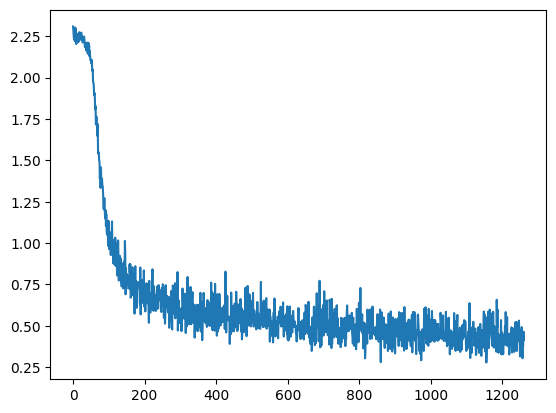

Test accuracy is: 86.00952673632452 %


In [57]:
BaseCNN = BaseConvNet()

criterion = nn.CrossEntropyLoss()

#Initialize optimizer 
learning_rate = .001
optimizer = torch.optim.Adam(BaseCNN.parameters(), lr = learning_rate)


# Device configuration (choose GPU if it is available )
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
BaseCNN.to(device)
num_epochs_ez = 3
# Train and test the model
loss_hist_ez = train(BaseCNN, train_loader, optimizer, num_epochs_ez, model_name='ez_model.pkt', device=device)

num_epochs_hard = 2
loss_hist_hard = train_hard(BaseCNN, train_loader, optimizer, num_epochs_hard, prop=0.7, model_name='hard_model.pkt', device=device)

loss_hist = loss_hist_ez + loss_hist_hard
plt.plot(loss_hist)
plt.show()


print('Test accuracy is: {} %'.format(test(BaseCNN, test_loader,device=device)))

# Ex. 2

# **Building your own efficient Convolutional Network architecture for SVHN**

In the following,  you will need to build your own CNN architecture to predict digit numbers on the SVHN dataset. You are completely free to use any kind of layers and hyper-parameters for this purpose. Your goal is to acheive the maximum possible accuracy on the test set (the better, the higher score you'll get in the exercice). The only constraint is that your model should not contain more than 150K parameters. Below, we provide a simple code to compute the number of parameters in a model.

## Computing model parameters

In [58]:
# Compute model paramters
def compute_model_params(model):
  params = 0
  for p in model.parameters():
    params+= p.numel()
  return params

In [59]:
import torch
import torch.nn as nn

# ResNet style network
class ResSim(nn.Module):
    def __init__(self, num_classes=10):
        
        super(ResSim, self).__init__()
        
    
        self.conv11 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv12 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        
        self.conv21 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv22 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        
        self.fc = nn.Linear(8*8*64, num_classes)
        
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        out11 = self.relu(self.conv11(x))
        out12 = self.relu(self.conv12(out11)) + out11

        out = self.maxpool(out12)

        out21 = self.relu(self.conv21(out)) 
        out = self.relu(self.conv22(out21)) + out21
        out = self.maxpool(out)
        
        #print(out.shape)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out
# Initialize the model
model = ResSim(num_classes=10)
# Compute and print number of params
n_params = compute_model_params(model)
print("ResNet Parameters: " + str(n_params)) ## 
print("THIS MODEL CONTAINS 153K PARAMS, IT IS CONSIDERED NOT VALID FOR THE EXERCICE!!!!!!")

ResNet Parameters: 153546
THIS MODEL CONTAINS 153K PARAMS, IT IS CONSIDERED NOT VALID FOR THE EXERCICE!!!!!!


In [60]:
'''
1. Design and implement your own CNN. Given that the number of parameters must be small, you can check some papers focused on efficient CNN architectures and get some ideas.
  - MobileNet: https://arxiv.org/abs/1704.04861
  - MobileNet V2: https://arxiv.org/pdf/1801.04381.pdf
  - SqueezeNet: https://arxiv.org/abs/1602.07360
  - ShuffleNet: https://arxiv.org/abs/1707.01083
  - ESPNet V2: https://arxiv.org/abs/1811.11431
2. Train it and test it on SVHN using the provided code.
3. Discuss what approaches have you tried, why, and which ones have shown to be more beneficial.
'''


'\n1. Design and implement your own CNN. Given that the number of parameters must be small, you can check some papers focused on efficient CNN architectures and get some ideas.\n  - MobileNet: https://arxiv.org/abs/1704.04861\n  - MobileNet V2: https://arxiv.org/pdf/1801.04381.pdf\n  - SqueezeNet: https://arxiv.org/abs/1602.07360\n  - ShuffleNet: https://arxiv.org/abs/1707.01083\n  - ESPNet V2: https://arxiv.org/abs/1811.11431\n2. Train it and test it on SVHN using the provided code.\n3. Discuss what approaches have you tried, why, and which ones have shown to be more beneficial.\n'

## Sol. 2

### Define your own model and check the number of total parameters

In [61]:
class DWSConv(nn.Module): # depth-wise separable convolution
    def __init__(self, nin, nout):
        super(DWSConv, self).__init__()
        self.depthwise = nn.Conv2d(nin, nin, kernel_size=3, padding=1, groups=nin)
        self.pointwise = nn.Conv2d(nin, nout, kernel_size=1)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

In [62]:
# Define an standard CNN -> Two conv. blocks and linear layer 
import torch.nn as nn
class GavamarNet(nn.Module):
    def __init__(self, num_classes=10):
        
        super(GavamarNet, self).__init__()
        
        self.conv11 = nn.Conv2d(3, 16, kernel_size=3,  padding=1) 
        self.conv12 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.conv13 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        # after maxpooling, the dimensions are 16x16x16

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv23 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        # after maxpooling, the dimensions are 8x8x32

        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv33 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        # after maxpooling, the dimensions are 4x4x64
        
        self.fc = nn.Linear(4*4*64, num_classes,)
        
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool= nn.AvgPool2d(kernel_size=2, stride=2)

        self.relu = nn.ReLU()
        self.bn12 = nn.BatchNorm2d(16)
        self.bn13 = nn.BatchNorm2d(16)
        self.bn14 = nn.BatchNorm2d(16)

        self.bn22 = nn.BatchNorm2d(32)
        self.bn23 = nn.BatchNorm2d(32)
        self.bn24 = nn.BatchNorm2d(32)

        self.bn32 = nn.BatchNorm2d(64)
        self.bn33 = nn.BatchNorm2d(64)
        self.bn34 = nn.BatchNorm2d(64)
        # self.logsoftmax = nn.LogSoftmax(dim=1).cuda()

# 
        
    def forward(self, x):
        
        out11 = self.conv11(x)
        out12 = self.relu(self.bn12(out11)) #preactivation
        out12 = self.conv12(out12) #convolution
        out13 = self.conv13(self.relu(self.bn13(out12))) #residual connection
        out   = out11 + out13 #skip connection
        out   = self.relu(self.bn14(out)) #postactivation
        out   = self.maxpool(out)

        out21 = self.conv21(out)
        out22 = self.conv22(self.relu(self.bn22(out21))) #preactivation and convolution
        out23 = self.conv23(self.relu(self.bn23(out22))) #residual connections
        out   = out21 + out23 #skip connection
        out   = self.relu(self.bn24(out)) #postactivation
        out   = self.maxpool(out)

        out31 = self.conv31(out)
        out32 = self.conv32(self.relu(self.bn32(out31))) #preactivation and convolution
        out33 = self.conv33(self.relu(self.bn33(out32))) #residual connections
        out   = out31 + out33 #skip connection
        out   = self.relu(self.bn34(out)) #postactivation
        out   = self.avgpool(out)
       
        out = out.reshape(out.size(0), -1) 
        out = self.fc(out)
        return out 

model = GavamarNet(num_classes=10)
n_params = compute_model_params(model)
print("MyModel Parameters: " + str(n_params))


MyModel Parameters: 131498


### Train your model on SVHN
It is not allowed to change training hyper-parameters such as learning rate, batch size or number of epochs. You can only modify the architecture definition.

In [63]:
## Create SVHN database

# All the data will be loaded from the provided file in Data/mnist.t
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as tf
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io as sio
import numpy as np

try: 
    base_path
except NameError:
    base_path = os.getcwd().replace('\\','/')
data_path = base_path + '/Data/'
results_path = base_path + '/Results/'

#Making native class loader
class SVHN(torch.utils.data.Dataset):
    # Initialization method for the dataset
    def __init__(self,dataDir = data_path+'/svhn/train_32x32.mat',transform = None):
        mat_loaded = sio.loadmat(dataDir)
        self.data = mat_loaded['X']
        self.labels = mat_loaded['y'].squeeze()
        self.labels -= self.labels.min()
        self.transform = transform
     # What to do to load a single item in the dataset ( read image and label)    
    def __getitem__(self, index):
        data = self.data[:,:,:,index]
        lbl = self.labels[index]
        
        data = Image.fromarray(data)
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None : 
            data = self.transform(data)
        
        # return the image and the label
        return data,lbl
    
        pass
    
    # Return the number of images
    def __len__(self):
        return self.data.shape[3]

# Create train data loader
tr = tf.Compose([
        tf.ToTensor(), 
        tf.Normalize(mean = [.5], std = [.5])
        ])
SVHNTrain = SVHN(data_path+'/svhn/train_32x32.mat',tr)
train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain,
                                               batch_size=256, 
                                               shuffle=True)

In [64]:
# Train function
def train(CNN, train_loader, optimizer, num_epochs=5, model_name='model.ckpt', device='cpu'):
    CNN.train() # Set the model in train mode
    total_step = len(train_loader)
    losses_list = []
    criterion = nn.CrossEntropyLoss()
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        loss_avg = 0
        nBatches = 0
        for i, (images, labels) in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.type(torch.LongTensor).to(device)

            # Forward pass
            outputs = CNN(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #print the parameters that are being updated
            # for name, param in CNN.named_parameters():
            #    if not param.requires_grad:
            #        print (name, " frozen")
            

            loss_avg += loss.cpu().item()
            nBatches+=1
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        losses_list.append(loss_avg / nBatches)
        torch.save(CNN.state_dict(), results_path+ '/' + model_name)
          
    return losses_list 

# Test funcion
def test(CNN, test_loader):
  with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            # get network predictions
            outputs = CNN(images)

            # get predicted class
            _, predicted = torch.max(outputs.data, 1)

            # compare with the ground-truth
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # return accuracy
        return 100 * correct / total

In [65]:
#Train MyModel
my_model = GavamarNet()

#Initialize optimizer 
learning_rate = .1
optimizer = torch.optim.SGD(my_model.parameters(),lr = learning_rate, 
                            weight_decay=1e-5, momentum=0.9)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
my_model = my_model.to(device)

losses_list = train(my_model, train_loader, optimizer, num_epochs=10, model_name='GavamarNet.ckpt', device=device)


Epoch [1/10], Step [100/287], Loss: 1.1599
Epoch [1/10], Step [200/287], Loss: 0.7923
Epoch [1/10], Step [287/287], Loss: 0.6574
Epoch [2/10], Step [100/287], Loss: 0.3033
Epoch [2/10], Step [200/287], Loss: 0.2875
Epoch [2/10], Step [287/287], Loss: 0.2797
Epoch [3/10], Step [100/287], Loss: 0.2255
Epoch [3/10], Step [200/287], Loss: 0.2268
Epoch [3/10], Step [287/287], Loss: 0.2247
Epoch [4/10], Step [100/287], Loss: 0.1875
Epoch [4/10], Step [200/287], Loss: 0.1955
Epoch [4/10], Step [287/287], Loss: 0.1945
Epoch [5/10], Step [100/287], Loss: 0.1624
Epoch [5/10], Step [200/287], Loss: 0.1647
Epoch [5/10], Step [287/287], Loss: 0.1691
Epoch [6/10], Step [100/287], Loss: 0.1355
Epoch [6/10], Step [200/287], Loss: 0.1453
Epoch [6/10], Step [287/287], Loss: 0.1475
Epoch [7/10], Step [100/287], Loss: 0.1160
Epoch [7/10], Step [200/287], Loss: 0.1265
Epoch [7/10], Step [287/287], Loss: 0.1290
Epoch [8/10], Step [100/287], Loss: 0.1080
Epoch [8/10], Step [200/287], Loss: 0.1102
Epoch [8/10

### Test your model
As a reference, 93% of accuracy can be easily achieved by using only ~55000 parameters.

In [66]:
# Show results for all the trained models
SVHNTest = SVHN(data_path+'/svhn/test_32x32.mat',tr)
test_loader = torch.utils.data.DataLoader(dataset=SVHNTest,
                                               batch_size=256, 
                                               shuffle=True)

#
my_net = GavamarNet()
my_net.load_state_dict(torch.load(results_path + 'GavamarNet.ckpt'))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
my_net.to(device)
acc = test(my_net, test_loader)
print('Accuracy MyNet: ' + str(acc))

Accuracy MyNet: 93.82298709280884


# Ex. 3

In [67]:

'''
1. Use the implemented architecture in the previous exercice to solve the transfer learning
   task provided in the examples.
2. Try to fine-tune not only the last layer for the CNN but a larger subset of parameters.
2. Report the test accuracy in each case and discuss the results. 
'''

'\n1. Use the implemented architecture in the previous exercice to solve the transfer learning\n   task provided in the examples.\n2. Try to fine-tune not only the last layer for the CNN but a larger subset of parameters.\n2. Report the test accuracy in each case and discuss the results. \n'

## Sol. 3

### Initialize DataLoaders for Transfer Learning experiment

In [68]:
max_degree = 10
tr_train = tf.Compose([
        tf.ToTensor(),
        tf.Normalize(mean = [.5], std = [.5]),
        tf.RandomCrop(32, padding=4),
        tf.RandomRotation(max_degree)
        ])

# Big dataset with numbers from 1 to 8
SVHNTrain_TL = SVHN(data_path+'/svhn_tl/tl_train_32x32.mat',tr_train)
tl_train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain_TL,
                                               batch_size=256, 
                                               shuffle=True)

# 200 samples of 0s and 9s
SVHNTrain_TL_0_9 = SVHN(data_path+'/svhn_tl/tl_train_9_10_32x32.mat',tr_train)
tl_train_loader_0_9 = torch.utils.data.DataLoader(dataset=SVHNTrain_TL_0_9,
                                                  batch_size=64, 
                                                  shuffle=True)
# Test dataset with 0 and 9s
SVHNTest_TL_0_9 = SVHN(data_path+'/svhn_tl/tl_test_9_10_32x32.mat',tr)
tl_test_loader_0_9 = torch.utils.data.DataLoader(dataset=SVHNTest_TL_0_9,
                                                  batch_size=64, 
                                                  shuffle=True)

### Pre-train your model with the big dataset with numbers from 1 to 8

In [69]:

gavamarnet_tl = GavamarNet(num_classes=8)
#Initialize optimizer 
learning_rate = .1
optimizer = torch.optim.SGD(gavamarnet_tl.parameters(),lr = learning_rate, weight_decay=1e-5, momentum=0.9)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
gavamarnet_tl = gavamarnet_tl.to(device)

losses_it = train(gavamarnet_tl, tl_train_loader, optimizer, num_epochs=10, model_name='tl_gavamarnet_svhn.ckpt', device=device)


Epoch [1/10], Step [100/249], Loss: 1.8373
Epoch [1/10], Step [200/249], Loss: 1.3631
Epoch [1/10], Step [249/249], Loss: 1.2063
Epoch [2/10], Step [100/249], Loss: 0.4581
Epoch [2/10], Step [200/249], Loss: 0.4274
Epoch [2/10], Step [249/249], Loss: 0.4162
Epoch [3/10], Step [100/249], Loss: 0.3236
Epoch [3/10], Step [200/249], Loss: 0.3169
Epoch [3/10], Step [249/249], Loss: 0.3119
Epoch [4/10], Step [100/249], Loss: 0.2678
Epoch [4/10], Step [200/249], Loss: 0.2678
Epoch [4/10], Step [249/249], Loss: 0.2704
Epoch [5/10], Step [100/249], Loss: 0.2535
Epoch [5/10], Step [200/249], Loss: 0.2460
Epoch [5/10], Step [249/249], Loss: 0.2441
Epoch [6/10], Step [100/249], Loss: 0.2294
Epoch [6/10], Step [200/249], Loss: 0.2249
Epoch [6/10], Step [249/249], Loss: 0.2252
Epoch [7/10], Step [100/249], Loss: 0.2222
Epoch [7/10], Step [200/249], Loss: 0.2195
Epoch [7/10], Step [249/249], Loss: 0.2168
Epoch [8/10], Step [100/249], Loss: 0.2070
Epoch [8/10], Step [200/249], Loss: 0.2049
Epoch [8/10

### Fine-tune the pretrained network with the small dataset of 9s and 0s

Number of filtered parameters: 36
Epoch [1/10], Step [4/4], Loss: 0.6924
Epoch [2/10], Step [4/4], Loss: 0.6152
Epoch [3/10], Step [4/4], Loss: 0.5619
Epoch [4/10], Step [4/4], Loss: 0.4816
Epoch [5/10], Step [4/4], Loss: 0.4679
Epoch [6/10], Step [4/4], Loss: 0.3866
Epoch [7/10], Step [4/4], Loss: 0.3397
Epoch [8/10], Step [4/4], Loss: 0.3167
Epoch [9/10], Step [4/4], Loss: 0.2439
Epoch [10/10], Step [4/4], Loss: 0.2090


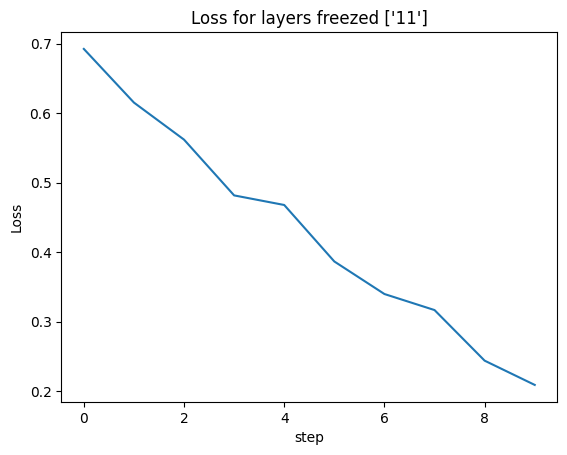

Accuracy GavamarNet Transfer Learning with layers freezed ['11']: 94.0682470500691 

Number of filtered parameters: 32
Epoch [1/10], Step [4/4], Loss: 0.6968
Epoch [2/10], Step [4/4], Loss: 0.6160
Epoch [3/10], Step [4/4], Loss: 0.5483
Epoch [4/10], Step [4/4], Loss: 0.4952
Epoch [5/10], Step [4/4], Loss: 0.4305
Epoch [6/10], Step [4/4], Loss: 0.3772
Epoch [7/10], Step [4/4], Loss: 0.3437
Epoch [8/10], Step [4/4], Loss: 0.2915
Epoch [9/10], Step [4/4], Loss: 0.2400
Epoch [10/10], Step [4/4], Loss: 0.2761


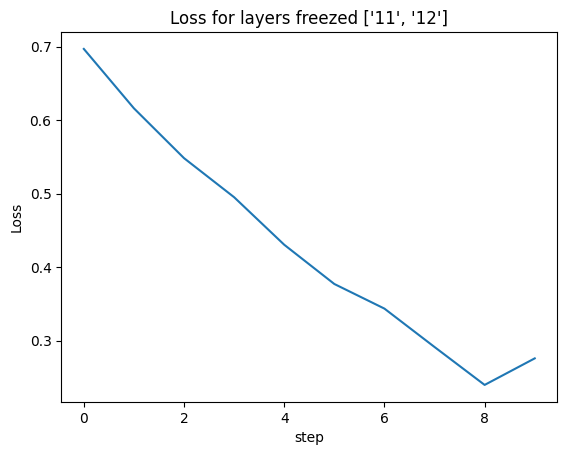

Accuracy GavamarNet Transfer Learning with layers freezed ['11', '12']: 94.142659721484 

Number of filtered parameters: 28
Epoch [1/10], Step [4/4], Loss: 0.6443
Epoch [2/10], Step [4/4], Loss: 0.5725
Epoch [3/10], Step [4/4], Loss: 0.5186
Epoch [4/10], Step [4/4], Loss: 0.4562
Epoch [5/10], Step [4/4], Loss: 0.3877
Epoch [6/10], Step [4/4], Loss: 0.3412
Epoch [7/10], Step [4/4], Loss: 0.2737
Epoch [8/10], Step [4/4], Loss: 0.2532
Epoch [9/10], Step [4/4], Loss: 0.2011
Epoch [10/10], Step [4/4], Loss: 0.2363


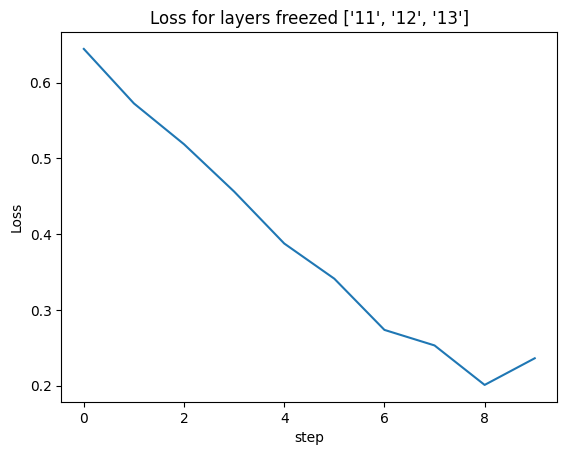

Accuracy GavamarNet Transfer Learning with layers freezed ['11', '12', '13']: 95.19506750292335 

Number of filtered parameters: 26
Epoch [1/10], Step [4/4], Loss: 0.6773
Epoch [2/10], Step [4/4], Loss: 0.5976
Epoch [3/10], Step [4/4], Loss: 0.5234
Epoch [4/10], Step [4/4], Loss: 0.4830
Epoch [5/10], Step [4/4], Loss: 0.4057
Epoch [6/10], Step [4/4], Loss: 0.4355
Epoch [7/10], Step [4/4], Loss: 0.3013
Epoch [8/10], Step [4/4], Loss: 0.2764
Epoch [9/10], Step [4/4], Loss: 0.2759
Epoch [10/10], Step [4/4], Loss: 0.1942


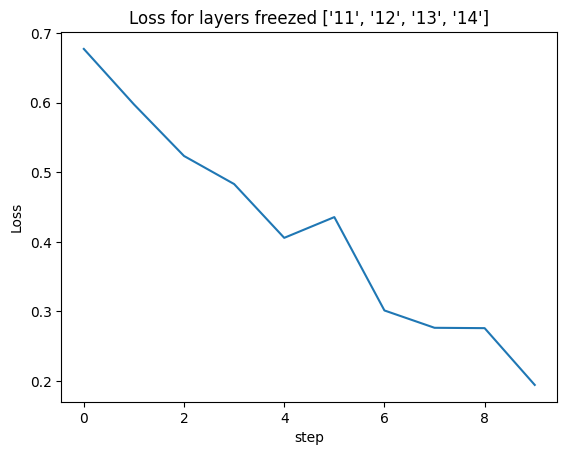

Accuracy GavamarNet Transfer Learning with layers freezed ['11', '12', '13', '14']: 94.78048261932604 

Number of filtered parameters: 24
Epoch [1/10], Step [4/4], Loss: 0.6461
Epoch [2/10], Step [4/4], Loss: 0.5697
Epoch [3/10], Step [4/4], Loss: 0.5087
Epoch [4/10], Step [4/4], Loss: 0.4829
Epoch [5/10], Step [4/4], Loss: 0.3912
Epoch [6/10], Step [4/4], Loss: 0.3233
Epoch [7/10], Step [4/4], Loss: 0.2553
Epoch [8/10], Step [4/4], Loss: 0.2221
Epoch [9/10], Step [4/4], Loss: 0.2106
Epoch [10/10], Step [4/4], Loss: 0.1775


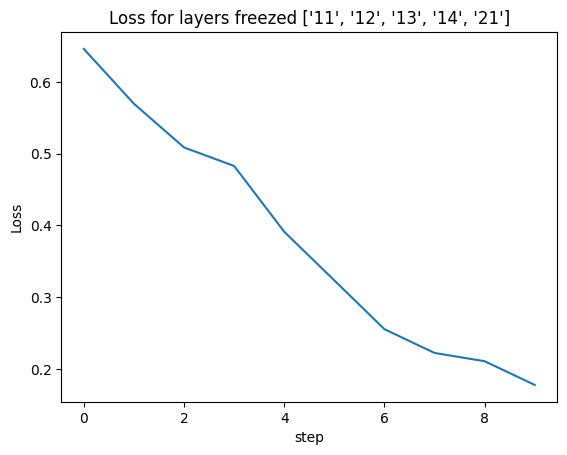

Accuracy GavamarNet Transfer Learning with layers freezed ['11', '12', '13', '14', '21']: 95.15254597640055 

Number of filtered parameters: 20
Epoch [1/10], Step [4/4], Loss: 0.6819
Epoch [2/10], Step [4/4], Loss: 0.6358
Epoch [3/10], Step [4/4], Loss: 0.5704
Epoch [4/10], Step [4/4], Loss: 0.4967
Epoch [5/10], Step [4/4], Loss: 0.4197
Epoch [6/10], Step [4/4], Loss: 0.3808
Epoch [7/10], Step [4/4], Loss: 0.3321
Epoch [8/10], Step [4/4], Loss: 0.2718
Epoch [9/10], Step [4/4], Loss: 0.2414
Epoch [10/10], Step [4/4], Loss: 0.2266


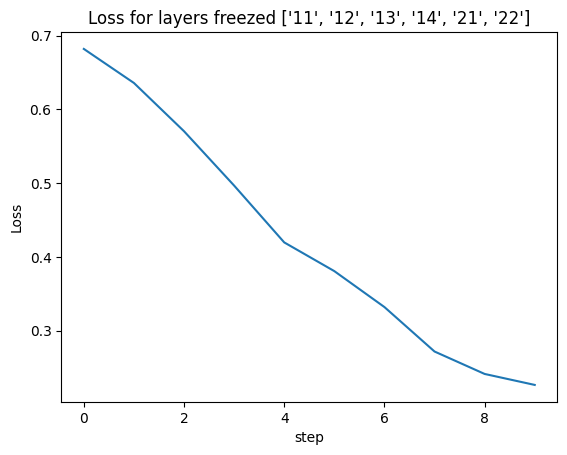

Accuracy GavamarNet Transfer Learning with layers freezed ['11', '12', '13', '14', '21', '22']: 94.49346231529712 

Number of filtered parameters: 16
Epoch [1/10], Step [4/4], Loss: 0.6517
Epoch [2/10], Step [4/4], Loss: 0.6080
Epoch [3/10], Step [4/4], Loss: 0.5637
Epoch [4/10], Step [4/4], Loss: 0.4915
Epoch [5/10], Step [4/4], Loss: 0.4570
Epoch [6/10], Step [4/4], Loss: 0.3896
Epoch [7/10], Step [4/4], Loss: 0.3544
Epoch [8/10], Step [4/4], Loss: 0.3129
Epoch [9/10], Step [4/4], Loss: 0.2400
Epoch [10/10], Step [4/4], Loss: 0.2329


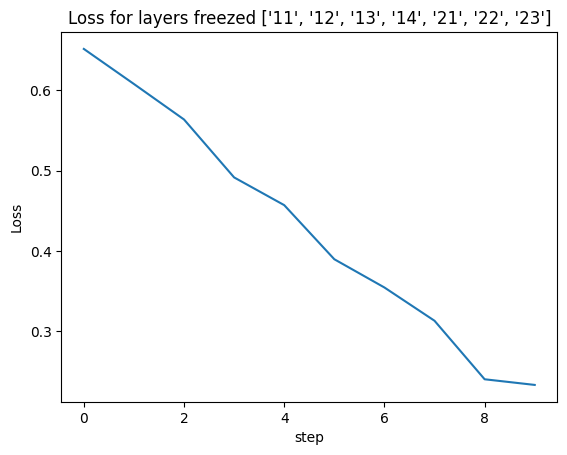

Accuracy GavamarNet Transfer Learning with layers freezed ['11', '12', '13', '14', '21', '22', '23']: 94.61039651323483 

Number of filtered parameters: 14
Epoch [1/10], Step [4/4], Loss: 0.6945
Epoch [2/10], Step [4/4], Loss: 0.6144
Epoch [3/10], Step [4/4], Loss: 0.5739
Epoch [4/10], Step [4/4], Loss: 0.5167
Epoch [5/10], Step [4/4], Loss: 0.4712
Epoch [6/10], Step [4/4], Loss: 0.3931
Epoch [7/10], Step [4/4], Loss: 0.3559
Epoch [8/10], Step [4/4], Loss: 0.3313
Epoch [9/10], Step [4/4], Loss: 0.2553
Epoch [10/10], Step [4/4], Loss: 0.2428


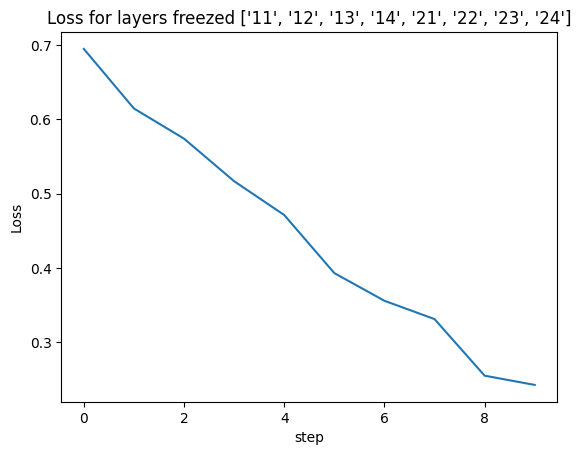

Accuracy GavamarNet Transfer Learning with layers freezed ['11', '12', '13', '14', '21', '22', '23', '24']: 94.70606994791113 

Number of filtered parameters: 12
Epoch [1/10], Step [4/4], Loss: 0.6726
Epoch [2/10], Step [4/4], Loss: 0.6255
Epoch [3/10], Step [4/4], Loss: 0.5802
Epoch [4/10], Step [4/4], Loss: 0.5290
Epoch [5/10], Step [4/4], Loss: 0.4630
Epoch [6/10], Step [4/4], Loss: 0.4357
Epoch [7/10], Step [4/4], Loss: 0.3802
Epoch [8/10], Step [4/4], Loss: 0.3517
Epoch [9/10], Step [4/4], Loss: 0.3565
Epoch [10/10], Step [4/4], Loss: 0.2611


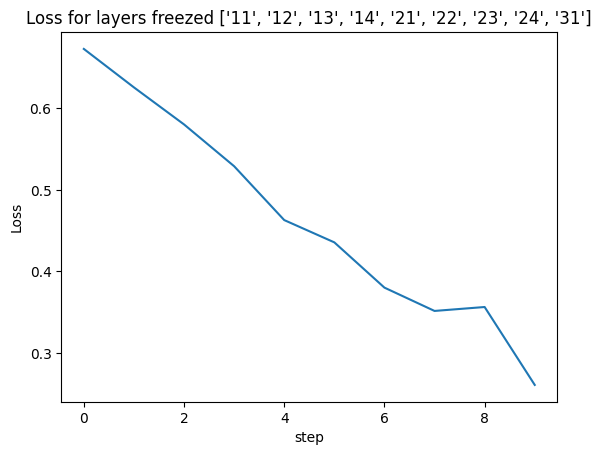

Accuracy GavamarNet Transfer Learning with layers freezed ['11', '12', '13', '14', '21', '22', '23', '24', '31']: 94.51472307855852 

Number of filtered parameters: 8
Epoch [1/10], Step [4/4], Loss: 0.7116
Epoch [2/10], Step [4/4], Loss: 0.6569
Epoch [3/10], Step [4/4], Loss: 0.6217
Epoch [4/10], Step [4/4], Loss: 0.5820
Epoch [5/10], Step [4/4], Loss: 0.5357
Epoch [6/10], Step [4/4], Loss: 0.5287
Epoch [7/10], Step [4/4], Loss: 0.4708
Epoch [8/10], Step [4/4], Loss: 0.4061
Epoch [9/10], Step [4/4], Loss: 0.4001
Epoch [10/10], Step [4/4], Loss: 0.3866


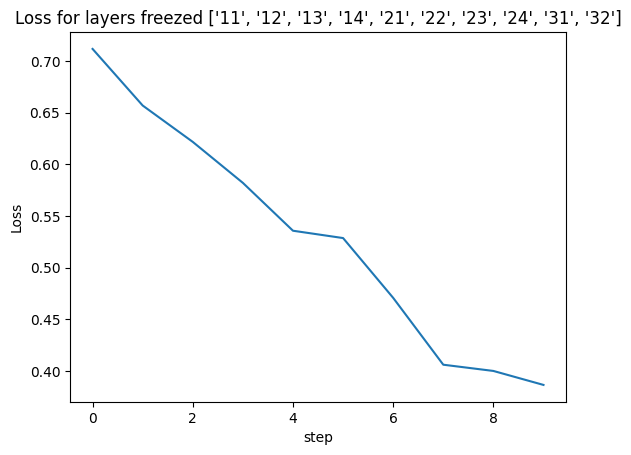

Accuracy GavamarNet Transfer Learning with layers freezed ['11', '12', '13', '14', '21', '22', '23', '24', '31', '32']: 92.50558095035612 

Number of filtered parameters: 4
Epoch [1/10], Step [4/4], Loss: 0.6545
Epoch [2/10], Step [4/4], Loss: 0.6112
Epoch [3/10], Step [4/4], Loss: 0.5657
Epoch [4/10], Step [4/4], Loss: 0.5666
Epoch [5/10], Step [4/4], Loss: 0.5447
Epoch [6/10], Step [4/4], Loss: 0.5364
Epoch [7/10], Step [4/4], Loss: 0.4932
Epoch [8/10], Step [4/4], Loss: 0.4866
Epoch [9/10], Step [4/4], Loss: 0.4674
Epoch [10/10], Step [4/4], Loss: 0.4494


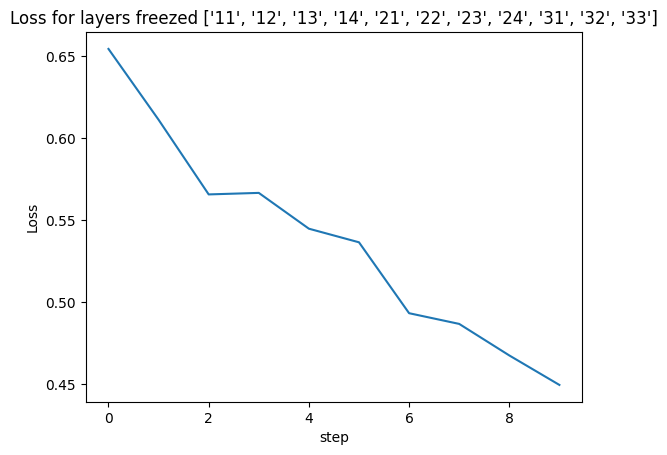

Accuracy GavamarNet Transfer Learning with layers freezed ['11', '12', '13', '14', '21', '22', '23', '24', '31', '32', '33']: 92.62251514829383 

Number of filtered parameters: 2
Epoch [1/10], Step [4/4], Loss: 0.6728
Epoch [2/10], Step [4/4], Loss: 0.6484
Epoch [3/10], Step [4/4], Loss: 0.6231
Epoch [4/10], Step [4/4], Loss: 0.5971
Epoch [5/10], Step [4/4], Loss: 0.5712
Epoch [6/10], Step [4/4], Loss: 0.5434
Epoch [7/10], Step [4/4], Loss: 0.5197
Epoch [8/10], Step [4/4], Loss: 0.4929
Epoch [9/10], Step [4/4], Loss: 0.4923
Epoch [10/10], Step [4/4], Loss: 0.4657


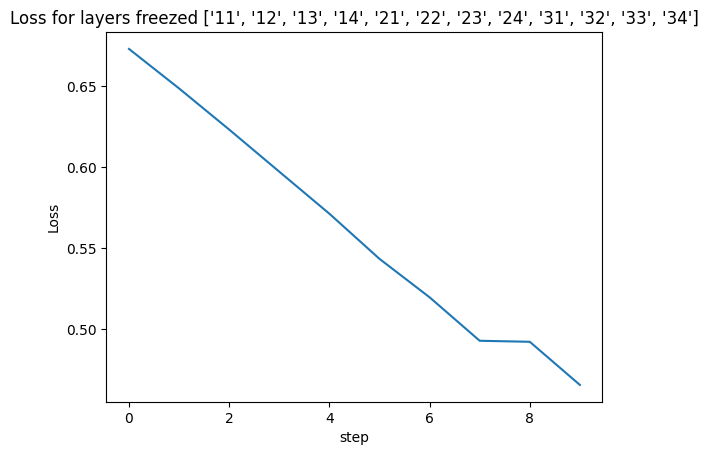

Accuracy GavamarNet Transfer Learning with layers freezed ['11', '12', '13', '14', '21', '22', '23', '24', '31', '32', '33', '34']: 91.89964919740619 



In [70]:
import time
criterion = nn.CrossEntropyLoss()
model = GavamarNet(num_classes=8)
layers = ['11', '12', '13','14', '21', '22', '23','24', '31', '32', '33','34']
arr_acc = []
arr_time = []
layers_to_freeze = list(range(1,len(layers)+1))
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
for num_freeze in layers_to_freeze:
    # copy the pretrained model
    fine_tuned_model = GavamarNet(num_classes=8)
    fine_tuned_model.load_state_dict(torch.load(results_path + 'tl_gavamarnet_svhn.ckpt'))
    fine_tuned_model = fine_tuned_model.to(device)
    fine_tuned_model.fc = nn.Linear(4*4*64, 2).to(device)
    
    # freeze layers
    for name, param in fine_tuned_model.named_parameters():
        if any(layer in name for layer in layers[:num_freeze]):
            param.requires_grad = False
            # print(name, 'layer frozen')
    # get the optimizer
    learning_rate = .0005
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, fine_tuned_model.parameters()),lr = learning_rate,
                                 weight_decay=1e-5)
    filtered_params = list(filter(lambda p: p.requires_grad, fine_tuned_model.parameters()))
    num_params = len(filtered_params)
    print("Number of filtered parameters:", num_params)

    start_time = time.time()
    losses_freeze = train(fine_tuned_model, tl_train_loader_0_9, optimizer, num_epochs=10, model_name=f'tl_gavamarnet_svhn_{num_freeze}.ckpt', device=device)
    end_time = time.time()
    arr_time.append(end_time - start_time)
    plt.plot(losses_freeze)
    plt.title("Loss for layers freezed "+str(layers[:num_freeze]))
    plt.xlabel("step")
    plt.ylabel("Loss")
    plt.show()
    acc = test(fine_tuned_model, tl_test_loader_0_9)
    arr_acc.append(acc)
    print('Accuracy GavamarNet Transfer Learning with layers freezed '+str(layers[:num_freeze])+': ' + str(acc),"\n")


Plot of the accuracy and time computation for the training and validation sets during the fine-tuning process.

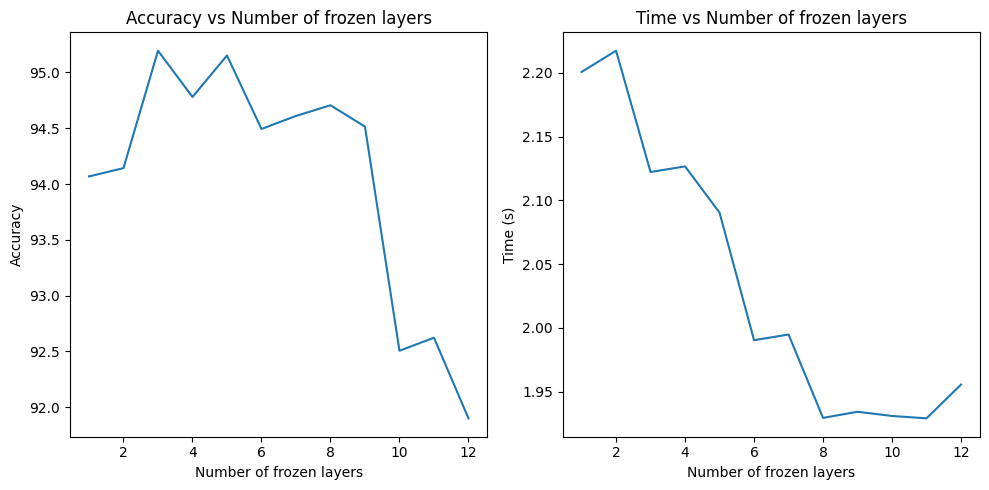

In [71]:

fig,axs = plt.subplots(1,2,figsize=(10,5))
axs[0].plot(layers_to_freeze,arr_acc)
axs[0].set_xlabel('Number of frozen layers')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Accuracy vs Number of frozen layers')
axs[1].plot(layers_to_freeze,arr_time)
axs[1].set_xlabel('Number of frozen layers')
axs[1].set_ylabel('Time (s)')
axs[1].set_title('Time vs Number of frozen layers')
fig.tight_layout()
plt.show()

### Demonstrating that  training from scratch is worse than transfer learning

In [72]:

gavamarnet_tl = GavamarNet(num_classes=2)
#Initialize optimizer 
learning_rate = .0005
optimizer = torch.optim.Adam(gavamarnet_tl.parameters(),lr = learning_rate)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
gavamarnet_tl = gavamarnet_tl.to(device)

losses_it = train(gavamarnet_tl, tl_train_loader_0_9, optimizer, num_epochs=10, model_name='tl_gavamarnet_svhn_only_0_9.ckpt', device=device)

acc= test(gavamarnet_tl, tl_test_loader_0_9)
print('Accuracy MyNet: ' + str(acc))

Epoch [1/10], Step [4/4], Loss: 0.7493
Epoch [2/10], Step [4/4], Loss: 0.7057
Epoch [3/10], Step [4/4], Loss: 0.6317
Epoch [4/10], Step [4/4], Loss: 0.5996
Epoch [5/10], Step [4/4], Loss: 0.6316
Epoch [6/10], Step [4/4], Loss: 0.5790
Epoch [7/10], Step [4/4], Loss: 0.5805
Epoch [8/10], Step [4/4], Loss: 0.5313
Epoch [9/10], Step [4/4], Loss: 0.5289
Epoch [10/10], Step [4/4], Loss: 0.4512
Accuracy MyNet: 69.42702243010524
